The source code for this project could be found [here](https://github.com/Xianzhiwang1/ml-0451-final-proj). We have a `README.md` file that outlines what our project want to achieve, and roughly how we are going to implement the models and analysis. We also have a separate `.txt` file that gives a dictionary of all the variable names and their actual meaning. Hence, we encourage the reader to also reference that `.txt` file to remember which variable means what.



First, let us import some libraries that will become useful down the road. Also, the following snippet will automatically reload the `final_project_code.py` file where we keep our functions.  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from final_project_code import FinalProject 

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from matplotlib.patches import Patch
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

In [37]:
from sklearn.metrics import roc_curve

Let us create an instance of the class we defined in `final_project_code.py`, and let us read in the entire data set.

In [4]:
FP = FinalProject()

In [5]:
Rvss = pd.read_csv("./AG_Corp_Prod_DataBase.csv")

/tmp/ipykernel_43367/139095848.py:1: DtypeWarning: Columns (3,13) have mixed types. Specify dtype option on import or set low_memory=False.
  Rvss = pd.read_csv("./AG_Corp_Prod_DataBase.csv")


First, let's do some data visualization. We are interested in seeing which industry in Late Imperial Russia had high machine power (measured in horsepower) and have high number of workers. We also want to get a sense of the distribution of machine power and number of workers, and visualize them by industry. Hence, let's focus on the picture below. We see that roughly, factory with more machine power tend to also have more workers, and most company cluster at the $2000$ horse power level, and $2500$ workers.   

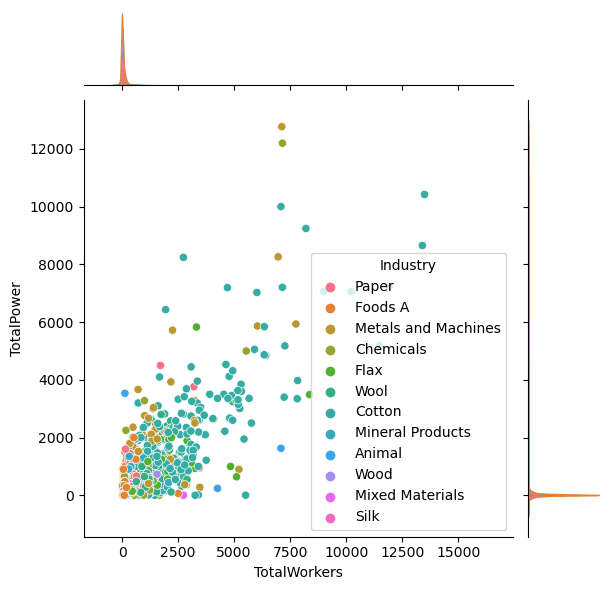

In [6]:
sns.jointplot(data=Rvss, x="TotalWorkers", y = "TotalPower", hue="Industry")

Similarly, here's another plot to visualize the unbalanced nature of the data set. Here, `Form` is the desired label that we want to predict. `Form` taking a value of $1$ means that factory was incorporated, i.e., it was owned by a incorporated firm. If `Form` take the value of $0$, then that factory was not incorporated. In the next plot, instead of `TotalPower`, which stands for Total amount of horse power and `TotalWorkers`, which stands for total number of workers, we use `logPowerperWorker` and `logRevperWorker` as our y-axis and our x-axis. `logPowerperWorker` is obtained by taking the log of $\frac{Power}{Worker}$, and `logRevperWorker` is log of $\frac{Revenue}{Worker}$. And the hue is whether the factory is encorporated or not. Again, we see that the orange dots, which corresponds to $1$, which corresponds to encorporated, is a very small percentage of all the factories. Most factories are not encorporated. Also, we observe that the data points follows a bell-shaped distribution on the two dimensions.  

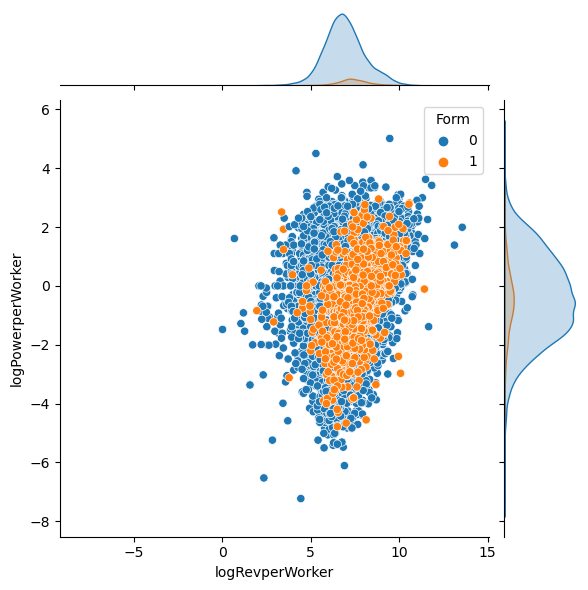

In [7]:
sns.jointplot(data=Rvss, x="logRevperWorker", y="logPowerperWorker", hue = "Form")

# Predicting whether Russian Factories want to incorporate or not
We start our analysis by using logistic regression to predict what kind of firms in late Imperial Russia is more likely owned by a corporation. Since our data is not balanced, we use several different approach to this problem and try them one at a time. Luckily for us, classification problem with unbalanced data labels is quite common, so we have many approaches at our disposal. 

Let us first get out definitions straight. Unbalanced data refers to those datasets where the target label has an uneven distribution of observations, 
 First, we try to randomly sample the majority data set, which in this case, is when the label equals unincorporated. Then we keep all the data entries of the minority data set, and add in the randomly sampled extract of the majority data set with size equal to the minority data set. Then we perform logistic regression on this new data set. The good news is that our new data set is balanced, and the bad news is that we loose a lot of information by discarding many data entries in the majority data set.  

### Read in the data 

In [8]:
import pandas as pd

# train_url = "./../Vermont_farm_tables/1850Midd.csv"
# train = pd.read_csv(train_url)

We download the replication data set and put it in the same directory as our project. After we read in the data, we notice that there are $66$ columns, which means potentially we could have around $60$ features for our machine learning model. However, let's start small. Hence, we begin our analysis using a subset of the columns. Also, since in the original data set, there's only a small percentage of factories that are incorporated, which is because of historical reasons in Late Imperial Russia during 1894 to 1908. For the purpose of this machine learning project, we artificially select a subset of the whole data set so that we have equal number of factories owned by incorporated firms and not incorporated firms alike.

In [9]:
# Rvss = pd.io.stata.read_stata("./../Rvssian/AG_Corp_RuscorpMasterFile_Cleaned.dta")
# Rvss.to_csv("RvssianCorpMasterFileCleaned.csv")

In [10]:
# Rvss_data = pd.io.stata.read_stata("./AG_Corp_Prod_Database.dta")
# Rvss_data.to_csv("AG_Corp_Prod_DataBase.csv")

In [11]:
Rvss.loc[Rvss['Form']==0]

,Unnamed: 0,id,Form,PSZ,PSZ1900,FoundingYear,Province,Region,Industry,OntheSide,...,Animal,Wool,Cotton,MixedMaterials,Wood,Paper,MetalsandMachines,Foods,Chemical,Mineral
0,0,4156,0,NaN,NaN,1860.0,30,CentralIndustrial,Paper,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,52010,0,NaN,NaN,NaN,51,Previslitskii,Foods A,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,30937,0,NaN,NaN,NaN,41,CentralBlacksoil,Foods A,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,39923,0,NaN,NaN,NaN,3,Caucasus,Metals and Machines,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,3296,0,NaN,NaN,1882.0,11,Northwestern,Chemicals,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37964,37964,34420,0,NaN,NaN,NaN,30,CentralIndustrial,Mineral Products,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
37965,37965,34210,0,NaN,NaN,NaN,19,CentralIndustrial,Mineral Products,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
37966,37966,52603,0,NaN,NaN,NaN,17,Southern,Foods A,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
37967,37967,4886,0,NaN,NaN,NaN,61,CentralIndustrial,Mineral Products,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Rvss.columns

In [13]:
df = Rvss[['id', 'Form', 'FoundingYear',
       'Province', 'Region', 'Industry', 'OntheSide', 'Age', 'TaxedActivity',
       'YEAR', 'PSZLastYear', 'PSZ1908', 'SubindustryCode', 'STCAP', 'Revenue',
       'TotalWorkers', 'TotalPower', 'GrandTotalWorkers', 'RevperWorker',
       'PowerperWorker', 'RevperGrandWorker', 'PowerperGrandWorker',
       'logRevperWorker', 'logPowerperWorker', 'logRevperGrandWorker',
       'logPowerperGrandWorker', 'logRev', 'logWorkers', 'logPower',
       'RegIndGroup', 'RegIndYearGroup', 'ProvIndGroup', 'ProvIndYearGroup',
       'IndYearGroup', 'IndustryFactor', 'ProvinceFactor', 'YearFactor',
       'AKTS', 'PAI', 'factory_id', 'FormNextYear', 'FormNextNextYear',
       'FactoryisCorpin1894', 'FormNextYearin1894', 'FactoryisCorpin1900',
       'FormNextYearin1900', 'FactoryisCorpin1908', 'NEWDEV', 'SHARES',
       'STPRICE', 'BONDS', 'Silk', 'Flax', 'Animal', 'Wool', 'Cotton',
       'MixedMaterials', 'Wood', 'Paper', 'MetalsandMachines', 'Foods',
       'Chemical', 'Mineral']]

In [42]:
result = FP.create_balanced_data(df)

df incorporated have 2393 many rows
after balancing, df not incorporated have 2393 many rows


In [43]:
result['Form'].mean()

0.5

In [40]:
compression_opts = dict(method='zip', archive_name='artificially_balanced_Rvssian_Factory.csv')
result.to_csv('artificially_balanced_Rvssian_Factory.zip', index = False, compression=compression_opts)

In [23]:
FP = FinalProject()
train, validate, test = FP.split_data(result)

In [24]:
df_train, X_train, y_train = FP.prepare_data(train)
df_validate, X_validate, y_validate= FP.prepare_data(validate)
df_test, X_test, y_test = FP.prepare_data(test)

# Let's do some visualization

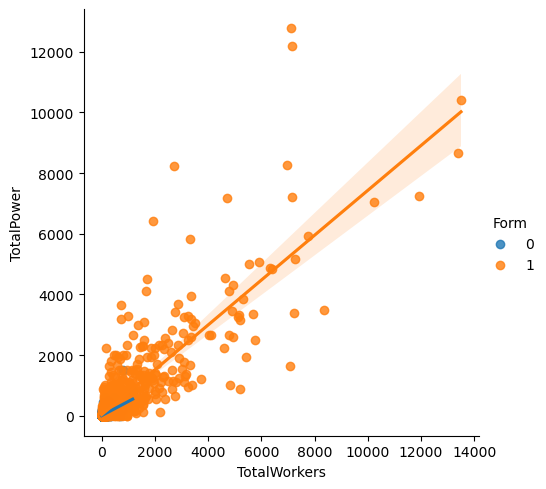

In [25]:
sns.lmplot(data=df_train, x="TotalWorkers", y = "TotalPower", hue="Form")

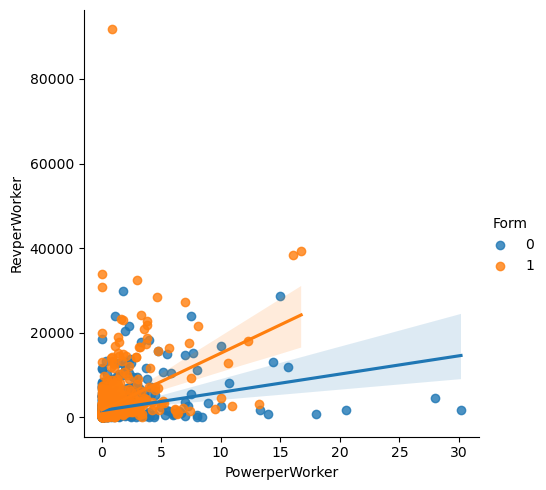

In [26]:
sns.lmplot(data=df_train, x="PowerperWorker", y = "RevperWorker", hue="Form")

# First, we try some feature engineering
In the basic toolbox of an economist, one is unlikely to find methods of feature engineering, since we believe that economists would rather choose the regressors (features) themselves, becuase regressors are often central to the economic questoin and analysis. However, in this project, we actually going to have a systematic way written in code to select the features.

In [27]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(X_train["Region"])
RegionCoded = le.transform(X_train["Region"])
le.fit(X_train["Industry"])
IndustryCoded = le.transform(X_train["Industry"])

X_train['RegionCoded'] = RegionCoded
X_train['IndustryCoded'] = IndustryCoded 
X_train = X_train.drop(columns='Region', axis = 1)
X_train = X_train.drop(columns='Industry', axis = 1)

In [28]:
X_train = X_train.fillna(0)
# X_train.head(10)

In [29]:
FP1 = FinalProject() 
all_qual_cols = ['RegionCoded', 'IndustryCoded'] 

all_quant_cols = [
      #  'Province', 'OntheSide', 'Age', 'TaxedActivity',
      #  'YEAR', 'PSZLastYear', 'PSZ1908', 'SubindustryCode', 'STCAP', 'Revenue',
       'TotalWorkers', 'TotalPower', 'GrandTotalWorkers', 'RevperWorker',
       'PowerperWorker', 'RevperGrandWorker', 'PowerperGrandWorker',
       'logRevperWorker', 'logPowerperWorker', 'logRevperGrandWorker',
       'logPowerperGrandWorker', 'logRev', 'logWorkers', 'logPower']
      #  'RegIndGroup', 'RegIndYearGroup', 'ProvIndGroup', 'ProvIndYearGroup',
      #  'IndYearGroup', 'IndustryFactor', 'ProvinceFactor', 'YearFactor',
      #  'AKTS', 'PAI', 'factory_id', 'FormNextYear', 'FormNextNextYear',
      #  'FactoryisCorpin1894', 'FormNextYearin1894', 'FactoryisCorpin1900',
      #  'FormNextYearin1900', 'FactoryisCorpin1908', 'NEWDEV', 'SHARES',
      #  'STPRICE', 'BONDS', 'Silk', 'Flax', 'Animal', 'Wool', 'Cotton',
      #  'MixedMaterials', 'Wood', 'Paper', 'MetalsandMachines', 'Foods',
      #  'Chemical', 'Mineral']
y_train = y_train.reset_index(drop=True)
FP1.feature_combo(all_qual_cols, all_quant_cols, X_train, y_train)    

In [30]:
max(FP1.feature_score_pair, key=FP1.feature_score_pair.get)

('RegionCoded', 'RevperWorker', 'logWorkers')

Hence, for fitting logistic regression on the training data, the highest scoring combination of 3 features among the independent variables that we considered is `RegionCoded`, `RevperGrandWorker`, `logWorkers`. 

In [31]:
# test for max 
max([-10, 5, 3], key=abs)
print(max(FP1.feature_score_pair.values()))
print(FP1.feature_score_pair[('RegionCoded', 'RevperGrandWorker', 'logWorkers')])

0.8056426332288401
0.8056426332288401


### The Prediction Question:
Can we predict which factory belongs to a incorporated company in Late Imerial Russia, during year 1894 and year 1908, by looking at other variables that are in the data? 

### Data Inspection
Since previously we have artificially selected a subset of our entire Russian factory data set so that we have equal number of factories belonging to incorporated firms and not incorporated firms, we expect that our label has roughly $50 \%$ of $1$'s and $50 \%$ % of $0$'s.

In [32]:
y_train.mean()

0.49808429118773945

In [33]:
df_train.groupby(['Industry'])[['Form']].aggregate([np.mean, len]).round(3)

Form     
                      mean  len
Industry                       
Animal               0.259  185
Chemicals            0.711  194
Cotton               0.835  333
Flax                 0.584  101
Foods A              0.271  501
Metals and Machines  0.594  470
Mineral Products     0.474  270
Mixed Materials      0.388   85
Paper                0.476  231
Silk                 0.381   42
Wood                 0.424  255
Wool                 0.475  204

Hence, it seems that Food industry in Late Imperial Russia had a low incorporation rate, which is around $28.3 \%$. On the other hand, the Cotton industry had a relatively high incorporation rate, around $81.4 \%$.

In [34]:
df_train.groupby(['Industry'])[['TotalPower']].aggregate([np.mean, len]).round(3)

TotalPower     
                          mean  len
Industry                           
Animal                  58.842  185
Chemicals              287.680  194
Cotton                1295.354  333
Flax                   605.966  101
Foods A                 68.968  501
Metals and Machines    274.785  470
Mineral Products        95.742  270
Mixed Materials         72.983   85
Paper                  254.000  231
Silk                    41.379   42
Wood                    59.426  255
Wool                   173.440  204

We see that Cotton industry has the highest mean total power, and Silk industry has the lowest mean total power. We might predict that industry with a higher need for capital might choose to incorporate. 
### Running some regressions 
We start with the standard procedure in Econometrics, which is running regressions. We first perform some regression analysis that is close in spirit to the published paper where this replication data set is coming from, and   

In [35]:


cols = ["id", "FoundingYear", "Industry", "TotalWorkers", "TotalPower", "GrandTotalWorkers", "logWorkers", "Mineral"]
cols = ['id', 'FoundingYear', 'Province', 'OntheSide', 'Age', 'TaxedActivity',
       'YEAR', 'PSZLastYear', 'PSZ1908', 'SubindustryCode', 'STCAP', 'Revenue',
       'TotalWorkers', 'TotalPower', 'GrandTotalWorkers', 'RevperWorker',
       'PowerperWorker', 'RevperGrandWorker', 'PowerperGrandWorker',
       'logRevperWorker', 'logPowerperWorker', 'logRevperGrandWorker',
       'logPowerperGrandWorker', 'logRev', 'logWorkers', 'logPower',
       'RegIndGroup', 'RegIndYearGroup', 'ProvIndGroup', 'ProvIndYearGroup',
       'IndYearGroup', 'IndustryFactor', 'ProvinceFactor', 'YearFactor',
       'AKTS', 'PAI', 'factory_id', 'FormNextYear', 'FormNextNextYear',
       'FactoryisCorpin1894', 'FormNextYearin1894', 'FactoryisCorpin1900',
       'FormNextYearin1900', 'FactoryisCorpin1908', 'NEWDEV', 'SHARES',
       'STPRICE', 'BONDS', 'Silk', 'Flax', 'Animal', 'Wool', 'Cotton',
       'MixedMaterials', 'Wood', 'Paper', 'MetalsandMachines', 'Foods',
       'Chemical', 'Mineral']
# X_train = X_train.dropna()
# X_train = X_train.drop(["Industry"], axis=1)
# X_train = X_train.drop(["Region"], axis=1)
# X_train.drop(["FoundingYear", "OntheSide", "TaxedActivity", "PSZLastYear", "PSZ1908"], axis=1)
X_train = X_train.fillna(0)
y_train.reset_index(drop=True)

cols = ['RevperGrandWorker', 'logWorkers']
LR = LogisticRegression()
LR.fit(X_train[cols], y_train)
LR.score(X_train[cols], y_train)

0.8032044583768722

In [36]:
# ROC curve, receiver operating characteristic
# TPR true positive rate
# FPR false positive rate
fpr, tpr, thresholds = roc_curve(y_train, scores, pos_label=2)

NameError: name 'scores' is not defined

In [ ]:
pd.DataFrame({
    "column": X_train[cols].columns,
    "coefficient": LR.coef_.ravel()
})

,column,coefficient
0,RevperGrandWorker,0.000077
1,logWorkers,1.064526


In [ ]:
isinstance(X_train[cols], np.ndarray)

False

In [ ]:
type(X_train[cols])
col=['TotalWorkers','TotalPower']
X_test[col]

,TotalWorkers,TotalPower
126,51.0,95.0
3950,79.0,0.0
2935,1948.0,0.0
3204,138.0,0.0
1347,38.0,4.0
...,...,...
4426,242.0,0.0
466,2.0,0.0
3092,104.0,70.0
3772,1.0,0.0


/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


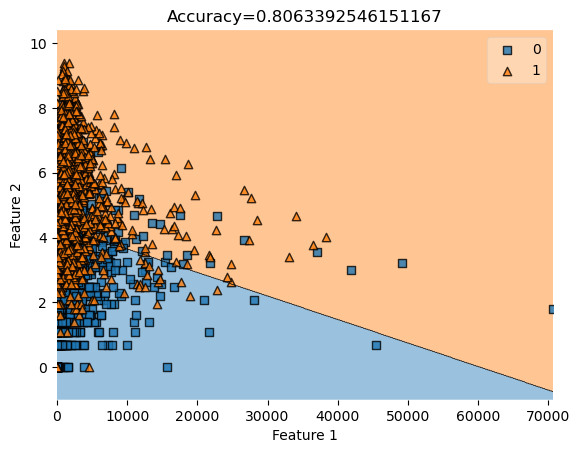

In [ ]:
# need to write up the function that make a visual representation
value=1.5
width=0.75
plot_decision_regions(X_train[cols].to_numpy(), y_train.to_numpy(), clf=LR
                    #   filler_feature_values={2:value},
                    #   filler_feature_ranges={2:width}
                      )
mypredict = LR.predict(X_train[cols].to_numpy())
title = plt.gca().set(title=f"Accuracy={(mypredict==y_train).mean()}",
                      xlabel="Feature 1",
                      ylabel="Feature 2")

ValueError: Filler values must be provided when X has more than 2 training features.

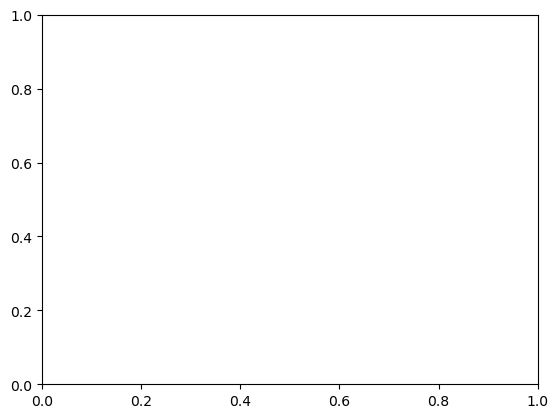

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions

clf = SVC(C=100,gamma=0.0001)
pca = PCA(n_components = 2)
X_train2 = pca.fit_transform(X_train[cols].to_numpy())
clf.fit(X_train[cols], y_train.to_numpy())
plot_decision_regions(X_train[cols].to_numpy(), y_train.to_numpy(), clf=clf, legend=2)

plt.xlabel(X_train[cols].to_numpy().columns[0], size=14)
plt.ylabel(X_train[cols].to_numpy().columns[1], size=14)
plt.title('SVM Decision Region Boundary', size=16)

#### Now we try Polynomial Features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [ ]:
def poly_LR(deg):
    return Pipeline([("poly", PolynomialFeatures(degree=deg)),
                     ("LR", LogisticRegression(penalty="none", max_iter=int(1e3)))])

In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(plr, X_train[cols], y_train, cv=5)
cv_scores

/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past beha

array([0.51130435, 0.50348432, 0.66376307, 0.67421603, 0.5087108 ])

In [ ]:
cv_scores.mean()

0.5722957127707924

Hence, this is telling us that for the features we selected, polynomial logistic regression has roughly the same predictive power as simply guessing whether a factory is belonging to a corporation or not. Degree zero corresponds to the baseline model, and degree 1 corresponds to simple logistic regression without a polynomial feature map.

In [ ]:
for deg in range(3):
    plr = poly_LR(deg = deg)
    cv_scores = cross_val_score(plr, X_train[cols], y_train, cv=5)
    mean_score = cv_scores.mean()  
    print(f"Polynomial degree = {deg}, score = {mean_score.round(3)}")

/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past beha

Polynomial degree = 0, score = 0.503


/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Polynomial degree = 1, score = 0.572


/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the pas

Polynomial degree = 2, score = 0.503


/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
plr = poly_LR(1)
plr.fit(X_train[cols], y_train)
plr.score(X_train[cols], y_train)
X_test = X_test.fillna(0)
plr.score(X_test[cols], y_test).round(4)

/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


0.6023

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_predict = plr.predict(X_test[cols])
print(confusion_matrix(y_test, y_predict))
print(classification_report(y_test, y_predict))

[[105 370]
 [ 11 472]]
              precision    recall  f1-score   support

           0       0.91      0.22      0.36       475
           1       0.56      0.98      0.71       483

    accuracy                           0.60       958
   macro avg       0.73      0.60      0.53       958
weighted avg       0.73      0.60      0.54       958



In [ ]:
confusion_matrix(y_test, y_predict, normalize = "true")

array([[0.22105263, 0.77894737],
       [0.02277433, 0.97722567]])

In [ ]:
X_test["PowerperWorker"].mean()

0.6977080826419624

In [ ]:
ix = X_test["PowerperWorker"] > 0.63483127
print("Factories with more power per worker than average")
print(f"The percentage our prediction is correct: {(y_test[ix] == y_predict[ix]).mean()}")
confusion_matrix(y_test[ix], y_predict[ix], normalize="true")

Factories with more power per worker than average
The percentage our prediction is correct: 0.6991525423728814


array([[0.34      , 0.66      ],
       [0.03676471, 0.96323529]])

In [ ]:

ix = X_test["PowerperWorker"] < 0.63483127
print("Factories with less power per worker than average")
print(f"The percentage our prediction matches the actual label: {(y_test[ix] == y_predict[ix]).mean()}")
confusion_matrix(y_test[ix], y_predict[ix], normalize="true")

Factories with less power per worker than average
The percentage our prediction matches the actual label: 0.5706371191135734


array([[0.18933333, 0.81066667],
       [0.01729107, 0.98270893]])

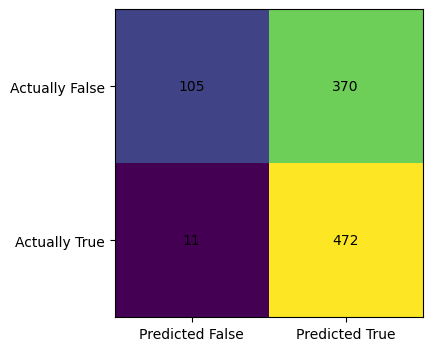

In [ ]:
my_matr = confusion_matrix(y_test, plr.predict(X_test[cols]))
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(my_matr)
ax.xaxis.set(ticks=(0,1), ticklabels=('Predicted False', 'Predicted True'))
ax.yaxis.set(ticks=(0,1), ticklabels=('Actually False', 'Actually True'))
ax.set_ylim(1.5, -0.5)

for i in range(2):
    for j in range(2):
        ax.text(j,i, my_matr[i,j], ha='center', va='center', color='black')

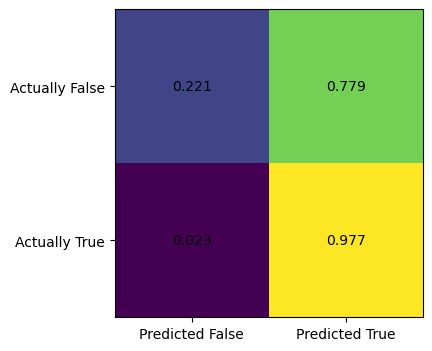

In [ ]:
y_test[X_test["PowerperWorker"] > 0.63483127]
FP1.print_confusion_matrix(plr, X_test[cols], y_test)